In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import mean_average_precision_for_user
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
ALGORITHMS = ['cbf', 'mf', 'user-user', 'hybrid_cbf_10', 'hybrid_cbf_11', 'hybrid_mf_10', 'hybrid_mf_11']

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(mean_average_precision_for_user(top_n, user_id))
    
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
        
        
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
        
        
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [3]:
width = 10 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

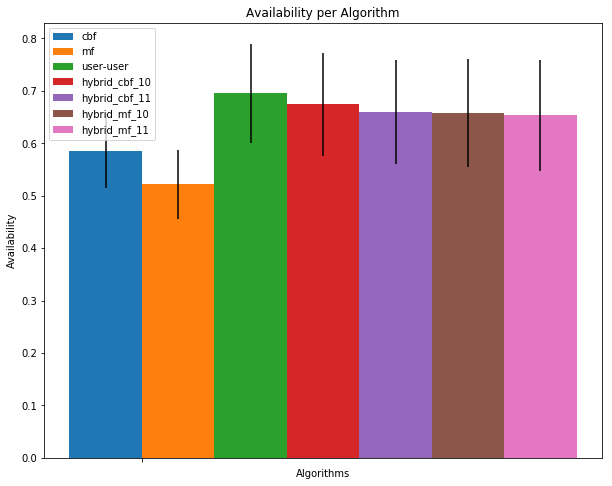

In [4]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [5]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.510899,0.532006,0.566868,0.623718,0.796855,0.802512,0.585363,0.480483,0.070753
mf,0.468187,0.468187,0.498603,0.564393,0.684572,0.684572,0.521616,0.468187,0.065243
user-user,0.567862,0.624114,0.688028,0.761760,0.908394,0.918805,0.695152,0.500692,0.094819
hybrid_cbf_10,0.552941,0.599488,0.672648,0.744888,0.883832,0.908289,0.674533,0.500692,0.098281
hybrid_cbf_11,0.523881,0.568400,0.654242,0.736993,0.861321,0.908289,0.660078,0.508016,0.098776
hybrid_mf_10,0.510899,0.585103,0.657337,0.736730,0.861321,0.908289,0.657054,0.468187,0.102834
hybrid_mf_11,0.498603,0.568212,0.653627,0.733178,0.861321,0.908289,0.652917,0.468187,0.105916


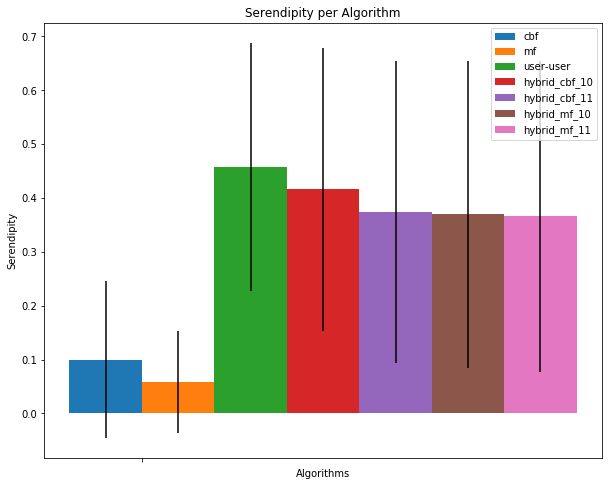

In [6]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [7]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.0,0.0,0.0,0.2,0.602,0.8,0.100,0.0,0.145602
mf,0.0,0.0,0.0,0.2,0.202,0.4,0.058,0.0,0.095058
user-user,0.2,0.2,0.4,0.6,0.802,1.0,0.458,0.0,0.230295
hybrid_cbf_10,0.0,0.2,0.4,0.6,0.802,1.0,0.416,0.0,0.263332
hybrid_cbf_11,0.0,0.2,0.4,0.6,0.802,1.0,0.374,0.0,0.280934
hybrid_mf_10,0.0,0.2,0.4,0.6,0.802,1.0,0.370,0.0,0.284781
hybrid_mf_11,0.0,0.0,0.4,0.6,0.802,1.0,0.366,0.0,0.288520


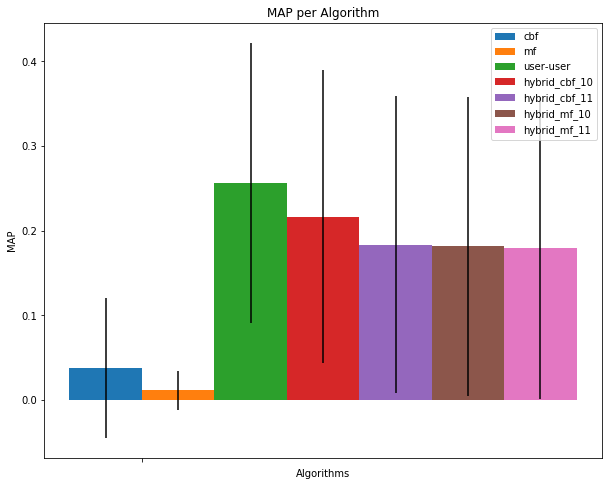

In [8]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [9]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.048214,0.459929,0.500,0.037413,0.0,0.082576
mf,0.000000,0.000000,0.000000,0.016667,0.091250,0.125,0.011453,0.0,0.023036
user-user,0.041667,0.125000,0.250000,0.375000,0.667600,0.760,0.256370,0.0,0.165848
hybrid_cbf_10,0.000000,0.061111,0.184259,0.333333,0.667600,0.760,0.216220,0.0,0.173249
hybrid_cbf_11,0.000000,0.035590,0.148380,0.302778,0.667600,0.760,0.183519,0.0,0.175589
hybrid_mf_10,0.000000,0.026984,0.148380,0.302778,0.667600,0.760,0.181389,0.0,0.177193
hybrid_mf_11,0.000000,0.020833,0.148380,0.302778,0.667600,0.760,0.179453,0.0,0.178563


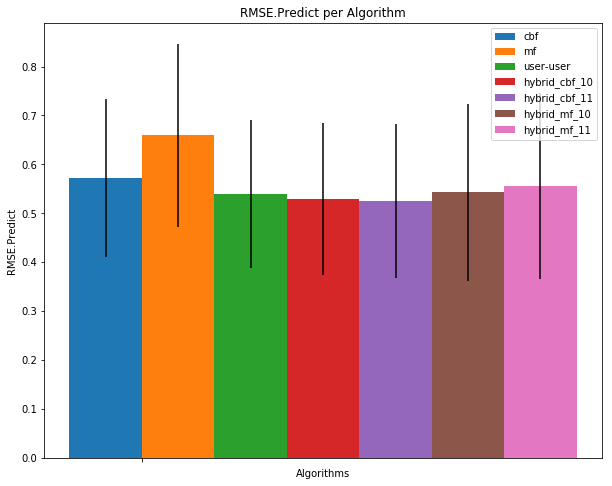

In [10]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [11]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.371323,0.458708,0.565546,0.665676,0.989574,1.017527,0.572387,0.266683,0.161299
mf,0.428535,0.524264,0.638710,0.746580,1.133340,1.258139,0.659029,0.311749,0.187732
user-user,0.379496,0.451870,0.521396,0.608613,0.961865,1.027937,0.539678,0.000000,0.150756
hybrid_cbf_10,0.360302,0.433645,0.504012,0.604373,0.961761,1.017527,0.528654,0.000000,0.154828
hybrid_cbf_11,0.358380,0.427540,0.504012,0.603204,0.989574,1.017527,0.525687,0.000000,0.157543
hybrid_mf_10,0.358975,0.432748,0.506085,0.605103,1.069060,1.258139,0.542431,0.000000,0.181487
hybrid_mf_11,0.360302,0.445374,0.508765,0.612164,1.133340,1.258139,0.555273,0.000000,0.190093


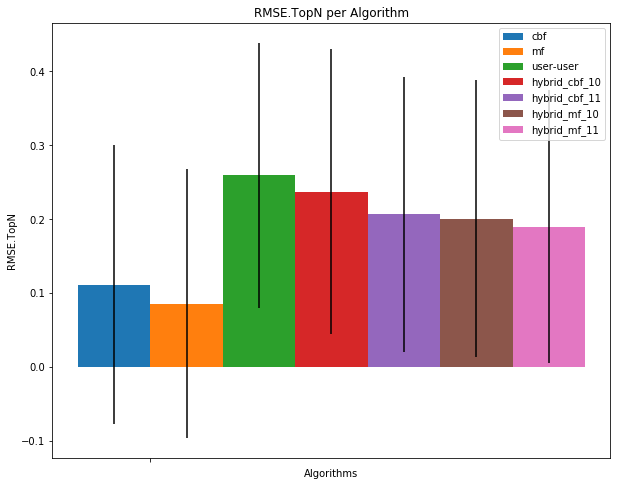

In [12]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [13]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.163600,0.641167,0.811303,0.111610,0.0,0.189255
mf,0.000000,0.000000,0.000000,0.057908,0.670296,0.885882,0.085722,0.0,0.181740
user-user,0.055927,0.117116,0.230005,0.399643,0.680138,0.931245,0.259641,0.0,0.179276
hybrid_cbf_10,0.000000,0.069966,0.193063,0.400282,0.680138,0.931245,0.237247,0.0,0.193006
hybrid_cbf_11,0.000000,0.031650,0.160085,0.363980,0.639830,0.677601,0.206644,0.0,0.186113
hybrid_mf_10,0.000000,0.016547,0.158995,0.346520,0.639830,0.677601,0.200864,0.0,0.187301
hybrid_mf_11,0.000000,0.005842,0.141508,0.341384,0.596695,0.677601,0.189739,0.0,0.184777


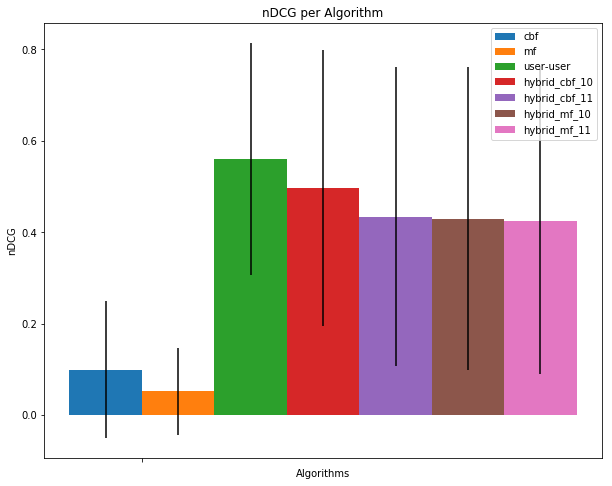

In [14]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [15]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.00000,0.000000,0.000000,0.166997,0.524354,0.717126,0.099567,0.0,0.149603
mf,0.00000,0.000000,0.000000,0.123814,0.376772,0.488985,0.051996,0.0,0.095357
user-user,0.22572,0.362692,0.560601,0.751403,0.995384,1.086058,0.560259,0.0,0.254591
hybrid_cbf_10,0.00000,0.290321,0.502453,0.746504,0.995384,1.086058,0.496434,0.0,0.302251
hybrid_cbf_11,0.00000,0.139628,0.427633,0.727202,0.995384,1.086058,0.434053,0.0,0.327407
hybrid_mf_10,0.00000,0.139628,0.427633,0.727202,0.995384,1.086058,0.429851,0.0,0.331279
hybrid_mf_11,0.00000,0.099888,0.427633,0.727202,0.995384,1.086058,0.425666,0.0,0.335368


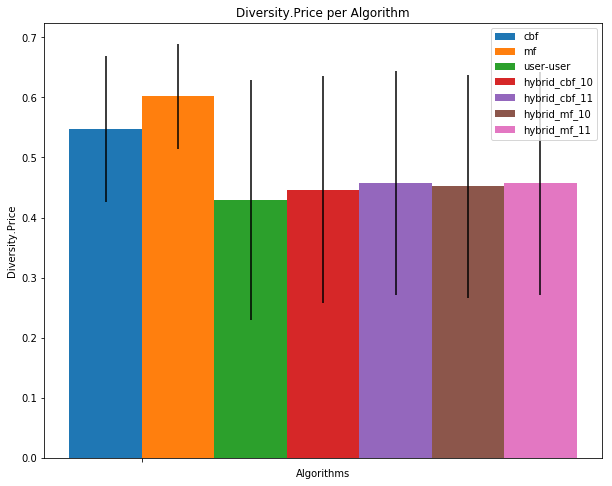

In [16]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [17]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.32,0.48,0.60,0.64,0.72,0.72,0.5472,0.24,0.121178
mf,0.40,0.64,0.64,0.64,0.64,0.64,0.6016,0.40,0.087985
user-user,0.16,0.32,0.48,0.56,0.72,0.72,0.4288,0.00,0.200006
hybrid_cbf_10,0.16,0.32,0.48,0.58,0.72,0.72,0.4464,0.00,0.189037
hybrid_cbf_11,0.16,0.32,0.48,0.64,0.72,0.72,0.4576,0.00,0.186275
hybrid_mf_10,0.16,0.32,0.48,0.64,0.72,0.72,0.4520,0.00,0.185343
hybrid_mf_11,0.16,0.38,0.48,0.64,0.72,0.72,0.4568,0.00,0.185660


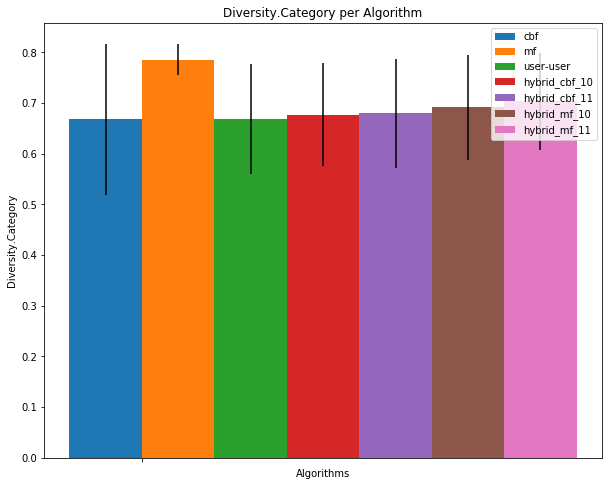

In [18]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [19]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.56,0.64,0.72,0.72,0.8,0.8,0.6680,0.00,0.149399
mf,0.72,0.80,0.80,0.80,0.8,0.8,0.7856,0.72,0.030735
user-user,0.56,0.56,0.72,0.72,0.8,0.8,0.6688,0.32,0.108234
hybrid_cbf_10,0.56,0.64,0.72,0.72,0.8,0.8,0.6768,0.32,0.101458
hybrid_cbf_11,0.56,0.64,0.72,0.72,0.8,0.8,0.6800,0.32,0.107629
hybrid_mf_10,0.56,0.64,0.72,0.80,0.8,0.8,0.6920,0.32,0.103923
hybrid_mf_11,0.56,0.64,0.72,0.80,0.8,0.8,0.7032,0.32,0.095529
